# Enron Anaylsis


### Contents
Exploratory Data Analysis
Pre-process/clean up the data if needed
Basic statistics to help understand the dataset
Explore and present initial insights found from the data
Use visualisation tools to help presentation of the insights
 Find an interesting area to further explore the dataset, e.g., topics modelling and clustering

### Background
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement, or plea deal with the government, or testified in exchange for prosecution immunity.


### Summary
A topic modeling tool takes a single text (or corpus) and looks for patterns in the use of words … A topic to the computer is a list of words that occur in statistically meaningful ways.

We plan to find themes of the emails sent by groupoing similar emails into topics and finding the most message sent for that topic. Before we look at the breakdown of the messages, such as time of sending, the distrubition of the people who have sent the messages. The aim is to find split the emails by topics to minimise the amount of human processing needed to find the root cause of the fraud scheme of the Enron company. As 500'000 emails is alot of go through. Tracking the people responsible and the contents of the emails, through the messages sent requires filtering. 

LDA is a topic modelling tool to find grouping of similar words in documents and grouping them up. By transforming the messages into vectors to represent the message and then grouping similar vectors in dimension together. 

We are able to show what similar messages are linked, who sent them and the themes and types of words that will be in them. 

In [1]:
import os, sys, email
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import plotly
#plotly.offline.init_notebook_mode()
#import plotly.graph_objs as go
import wordcloud

# Network analysis
import networkx as nx
# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

### Importing of the Inital data set in csv format

In [2]:
df = pd.read_csv("emails.csv")

## Exploratory Data Analysis

In [4]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


The details of the message are a single object. Therefore we extract the different attributes of the message

In [5]:
print(df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [6]:
def get_text(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        address = line.split(',')
        address = frozenset(map(lambda x: x.strip(), addrs))
    else:
        address = None
    return address

###  The details from the message are broken up into seperate columns

In [7]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, df['message']))

# Split email addresses
df['From'] = df['From'].map(split_addresses)
df['To'] = df['To'].map(split_addresses)

# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    df[key] = [doc[key] for doc in messages]
    
# Parse content from emails
df['content'] = list(map(get_text, messages))

# Extract the root of 'file' as 'user'
df['user'] = df['file'].map(lambda x:x.split('/')[0])

df.drop('message', axis=1, inplace=True)

df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


### The number of unique values for each of the fields

In [8]:
print('Dateframe Shape:', df.shape)
# Find number of unique values in each columns
for col in df.columns:
    print(col, df[col].nunique())

shape of the dataframe: (517401, 18)
file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


In [9]:
# Set index and drop columns with two few values
df = df.set_index('Message-ID').drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

# Parse datetime
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.dtypes

Date          object
From          object
To            object
Subject       object
X-From        object
X-To          object
X-cc          object
X-bcc         object
X-Folder      object
X-Origin      object
X-FileName    object
content       object
user          object
dtype: object

Text(0.5, 1.0, 'Number of emails a year')

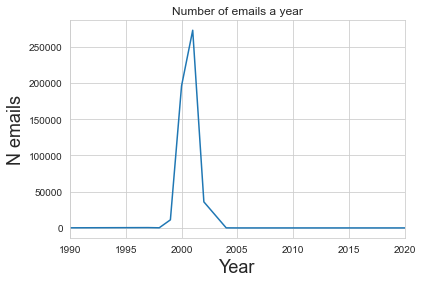

In [10]:
df['Date'] = pd.to_datetime(df['Date'], utc = True)
ax = df.groupby(df['Date'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)
ax.set_xlim(1990,2020)
ax.set_title("Number of emails a year")

Text(0.5, 1.0, 'Number of emails sent overall on a week')

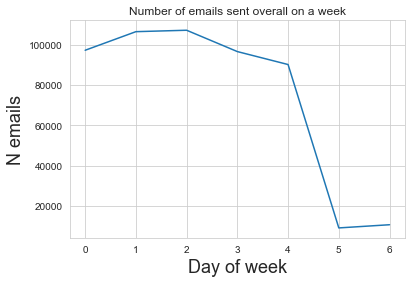

In [11]:
ax = df.groupby(df['Date'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Day of week', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)
ax.set_title("Number of emails sent overall on a week")

Text(0.5, 1.0, 'Number of emails sent on each hour of the day')

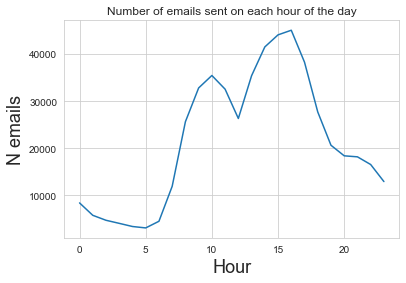

In [12]:
ax = df.groupby(df['Date'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)
ax.set_title("Number of emails sent on each hour of the day")

## Counting the average number of words in the content of an email and the subject of an email for each user

In [13]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
df['subject_wc'] = df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
df['content_wc'] = df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [14]:
grouped_by_people = df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })
grouped_by_people.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
grouped_by_people.sort_values('N emails', ascending=False).head()

,N emails,Subject word count,Content word count
user,,,
kaminski-v,28465,4.217530,255.906025
dasovich-j,28234,5.237373,603.393391
kean-s,25351,4.959331,490.837561
mann-k,23381,4.211796,207.195501
jones-t,19950,4.748221,185.462607


In [15]:
sub_df = df[['From', 'To', 'Date']].dropna()
print(sub_df.shape)
# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(495554, 3)
(354600, 3)


## The most number of emails sent between two email addresses

In [16]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
17908,pete.davis@enron.com,pete.davis@enron.com,9141
38033,vince.kaminski@enron.com,vkaminski@aol.com,4308
28920,enron.announcements@enron.com,all.worldwide@enron.com,2206
28935,enron.announcements@enron.com,all.houston@enron.com,1701
26510,kay.mann@enron.com,suzanne.adams@enron.com,1528
38031,vince.kaminski@enron.com,shirley.crenshaw@enron.com,1190
14564,steven.kean@enron.com,maureen.mcvicker@enron.com,1014
26309,kay.mann@enron.com,nmann@erac.com,980
18926,kate.symes@enron.com,evelyn.metoyer@enron.com,915
18930,kate.symes@enron.com,kerri.thompson@enron.com,859


In [17]:
df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,subject_wc,content_wc
Message-ID,,,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00+00:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,0,4
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00+00:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,1,130
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00+00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,2,5
<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00+00:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,0,32
<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00+00:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,2,7


# LDA

In [19]:
import pandas as pd

In [20]:
emails = pd.read_csv('emails.csv')
# email_subset = emails[:10000]
email_subset = emails.sample(frac=0.02, random_state=1)

print(email_subset.shape)
print(email_subset.head())

(10348, 2)
                              file  \
186822  jones-t/all_documents/634.   
308790  mann-k/all_documents/5690.   
82383         dasovich-j/sent/423.   
227299          kaminski-v/var/63.   
301824     mann-k/_sent_mail/3208.   

                                                  message  
186822  Message-ID: <17820178.1075846925335.JavaMail.e...  
308790  Message-ID: <29110382.1075845717882.JavaMail.e...  
82383   Message-ID: <6812040.1075843194135.JavaMail.ev...  
227299  Message-ID: <21547648.1075856642126.JavaMail.e...  
301824  Message-ID: <12684200.1075846107179.JavaMail.e...  


### Prepcorssing of the message for LDA
Breaking up the body of the emails into seperate fields

In [21]:
def parse_inital_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [22]:
def parse_emails(messages):
    emails = [parse_inital_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'),
        'to': map_to_list(emails, 'to'),
        'from_': map_to_list(emails, 'from')
    }


In [23]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [24]:
email_df = pd.DataFrame(parse_emails(email_subset.message))
print(email_df.head())

                                                body  \
0  It would be nice if you could be at my dinner,...   
1  Absolutely.Good point!  Can Peter start to dra...   
2  My apologies.  My schedule melted down after w...   
3  Vince,UK VAR breached the limit last week.UK t...   
4  Any problems/comments?AM ---------------------...   

                                                  to  \
0                           alicia.goodrow@enron.com   
1                          Kay Mann/Corp/Enron@ENRON   
2                        christine.piesco@oracle.com   
3  Richard Lewis/LON/ECT@ECT, James New/LON/ECT@E...   
4  Don Hammond/PDX/ECT@ECT, Jody Blackburn/PDX/EC...   

                               from_  
0               tana.jones@enron.com  
1  Sheila Tweed@ECT on 05/15/2001 06  
2            jeff.dasovich@enron.com  
3        tanya.tamarchenko@enron.com  
4                 kay.mann@enron.com  


### Importing of modules needed for LDA

In [26]:
import re
import numpy as np

import gensim

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

# spacy for lemmatization
import spacy

# for plotting
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt

In [27]:
# prep NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
print(email_df.iloc[2]['body']) # displays info below

My apologies.  My schedule melted down after we talked on Monday.  Here'swhere folks came out.  There's some concern about size.  We're supposed to beno larger than 3, but we lobbied Aceves and he apparently Ok'd our"oversized" group.  The other folks in the group--who talked to himoriginally--are pretty sure that five will violate the rules.  Folks wonderedif there were other groups that are smaller than ours that you could hook upwith.  Sorry about that---it's a wrinkle that I didn't think about when wespoke.  If it gets real ugly trying to find a smaller group, let me know.Fortunately there's not another team case due for two weeks.Best,Jeff


C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Preprocessing of the messages for LDA
Creating a list of words for vectorise

In [29]:
# Convert email body to list
data = email_df.body.values.tolist()

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# tokenize - break down each sentence into a list of words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
data_words = list(sent_to_words(data))

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
print(data_words[3])

['vince', 'uk', 'var', 'breached', 'the', 'limit', 'last', 'week', 'uk', 'traders', 'asked', 'us', 'to', 'review', 'the', 'correlations', 'across', 'uk', 'gas', 'and', 'power', 'aswell', 'as', 'the', 'correlations', 'across', 'efa', 'slots', 'we', 'did', 'part', 'of', 'the', 'work', 'last', 'week', 'now', 'we', 'll', 'update', 'the', 'correlations', 'based', 'on', 'historical', 'prices', 'tanya', 'richard', 'lewisleppard', 'lon', 'ect', 'ect', 'rudy', 'dautel', 'hou', 'ect', 'ect', 'kirstee', 'hewitt', 'lon', 'ect', 'ect', 'naveen', 'andrews', 'corp', 'enron', 'enron', 'david', 'port', 'market', 'risk', 'corp', 'enron', 'enron', 'tedmurphy', 'hou', 'ect', 'ect', 'simon', 'hastings', 'lon', 'ect', 'ect', 'paul', 'arcy', 'lon', 'ect', 'ect', 'amirghodsian', 'lon', 'ect', 'ectthanks', 'tanya', 'these', 'are', 'interesting', 'results', 'am', 'on', 'vacation', 'next', 'week', 'sohere', 'are', 'my', 'current', 'thoughts', 'am', 'contactable', 'on', 'my', 'mobile', 'if', 'necessary', 'gas', '

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Grouping words together 
Bigram a pair of consecutive written units such as letters, syllables, or words.
Trigram a group of three consecutive written units such as letters, syllables, or words.
Grouping words together to enrich information in feature extraction

In [33]:
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[200]]])

['image_image_image', 'getting', 'together', 'for', 'the', 'holidays', 'is', 'something', 'we', 'all', 'enjoy', 'whether', 'it', 'gathering', 'with', 'old', 'friends', 'from', 'out', 'of', 'town', 'or', 'hanging', 'out', 'with', 'the', 'usual', 'gang', 'every', 'gathering', 'this', 'time', 'of', 'year', 'seems', 'little', 'more', 'special', 'we', 'at', 'miller_brewing', 'wish', 'you', 'many', 'happy', 'celebrations', 'this', 'season', 'and', 'thank', 'you', 'for', 'enjoying', 'those', 'occasions', 'responsibly', 'happy_holidays', 'image', 'this', 'mail', 'is', 'not', 'sent', 'unsolicited', 'you', 'subscribed', 'to', 'receive', 'information', 'from', 'miller_brewing', 'at', 'miller', 'web_site', 'or', 'event', 'must', 'be', 'or', 'older', 'to', 'visit', 'our', 'web_site', 'miller_brewing', 'co', 'milwaukee', 'wi', 'miller_brewing', 'company', 'milwaukee', 'wi', 'privacy_statement', 'image_image_image_image', 'this', 'message', 'was', 'sent', 'by', 'miller_brewing', 'company', 'using', '

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# remove stop_words, make bigrams and lemmatize
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
print(data_lemmatized[200])

['image', 'get', 'together', 'holiday', 'enjoy', 'gather', 'old', 'friend', 'town', 'hang', 'usual', 'gang', 'gathering', 'time', 'year', 'seem', 'little', 'special', 'miller_brewing', 'wish', 'many', 'happy', 'celebration', 'season', 'thank', 'enjoy', 'occasion', 'responsibly', 'happy_holiday', 'image', 'mail', 'send', 'unsolicited', 'subscribe', 'receive', 'information', 'miller_brewe', 'event', 'old', 'visit', 'web_site', 'miller_brewe', 'co', 'miller_brewing', 'company', 'privacy', 'statement', 'message', 'send', 'miller_brewe', 'company', 'use', 'interact', 'tm', 'click', 'prefer', 'receive', 'future', 'mail', 'miller_brewe', 'company', 'click', 'view', 'permission', 'marketing', 'policy', 'image']


C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Feature extraction

In [39]:
# create dictionary and corpus both are needed for (LDA) topic modeling

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\BenSlater\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [42]:
print(lda_model.print_topics())# The weights reflect how important a keyword is to that topic.

[(0, '0.058*"pdf" + 0.022*"mary_hain" + 0.019*"allocate" + 0.013*"spreadsheet" + 0.008*"tanya" + 0.008*"iwill" + 0.006*"comhere" + 0.005*"ron_mcnamara" + 0.004*"nicolay" + 0.003*"spp"'), (1, '0.080*"message" + 0.055*"error" + 0.046*"doc" + 0.038*"attempt" + 0.038*"email" + 0.027*"delete" + 0.025*"org" + 0.020*"attachment" + 0.019*"receive" + 0.018*"confidential"'), (2, '0.035*"get" + 0.024*"go" + 0.024*"know" + 0.017*"good" + 0.017*"see" + 0.017*"time" + 0.016*"way" + 0.016*"think" + 0.015*"want" + 0.014*"let"'), (3, '0.105*"document" + 0.053*"section" + 0.038*"appropriate" + 0.037*"master" + 0.036*"immediately" + 0.025*"balance" + 0.025*"exhibit" + 0.020*"advance" + 0.018*"provision" + 0.018*"merger"'), (4, '0.034*"pretty" + 0.029*"sorry" + 0.016*"baja" + 0.011*"hook" + 0.011*"billing" + 0.010*"minister" + 0.010*"standardize" + 0.009*"apology" + 0.006*"accommodate" + 0.006*"bcf"'), (5, '0.041*"say" + 0.032*"power" + 0.029*"energy" + 0.026*"state" + 0.020*"market" + 0.017*"price" + 0.0

In [43]:
doc_lda = lda_model[corpus]

### However, how do we judge how well this model has done without inspecting every single topic?
Model Perplexity And Coherence
The perplexity and the coherence scores of our model give us a way to address this.

In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.

In [44]:
# Model perplexity and topic coherence provide a convenient
# measure to judge how good a given topic model is.
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -15.68879177930286


### You’ll find that Coherence score is a better predictor of the quality of topics as opposed to the Perplexity score.
This score is trying to quantify the semantic similarities of the high scoring words within each topic. A high score means the result is more human-interpretable.
So, naturally higher coherence score means a better model.

In [45]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.47064123835100646


In [46]:
# Visualize the topics
pyLDAvis.enable_notebook(sort=True)
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

### Results display

In [47]:
pyLDAvis.display(vis)

In [54]:
topics = [[(term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=20)] for n in range(0, lda_model.num_topics)]

In [56]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
Term1,pdf,message,get,document,pretty,say,house,river,game,mail,d,masud,company,ect,write,also,trade,priority,com,deal
Term2,mary_hain,error,go,section,sorry,power,revenue,oak,man,center,motion,eventstelecom,enron,hou,fund,information,open,busy,enron,thank
Term3,allocate,doc,know,appropriate,baja,energy,dinner,kay,love,global,publication,softswitch,business,corp,monitor,issue,rate,compensation,aol,agreement
Term4,spreadsheet,attempt,good,master,hook,state,prefer,sheraton,gift,guy,thus,economicfactor,service,lon,corporation,need,special,salary,michael,change
Term5,tanya,email,see,immediately,billing,market,glad,hotel,finally,table,certificate,discussnew,new,communication,mr,question,offer,eligible,net,attach


In [57]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df

<ipython-input-57-a1c8b6649ae4>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"pdf, mary_hain, allocate, spreadsheet, tanya, iwill, comhere, ron_mcnamara, nicolay, spp, david_portz, jeanne, ewe, gov, ewing, cera, adobe, sec, agriculture, walter_lukken"
Topic2,"message, error, doc, attempt, email, delete, org, attachment, receive, confidential, flight, rush, copy, intended_recipient, sender, intend, address, offer, contact, write"
Topic3,"get, go, know, good, see, time, way, think, want, let, thank, week, day, look, take, need, well, make, work, come"
Topic4,"document, section, appropriate, master, immediately, balance, exhibit, advance, provision, merger, wrong, turbine, shipper, guaranty, congratulation, pursuant, contemplate, clark, pursue, duran"
Topic5,"pretty, sorry, baja, hook, billing, minister, standardize, apology, accommodate, bcf, txu, themarket, ugly, consultation, yard, qb, smith, rb, fantasy, td"
Topic6,"say, power, energy, state, market, price, california, year, gas, utility, electricity, company, ferc, cost, plant, rate, supply, sell, buy, commission"
Topic7,"house, revenue, dinner, prefer, glad, ago, skill, sleep, command, unfortunately, valuable, kate, easily, cp, anywhere, anytime, strictly, quiet, hobby, band"
Topic8,"river, oak, kay, sheraton, hotel, car, den, det, nyj, sea, gb, pit, phi, sd, smith, jac, min, buf, hilton, sf"
Topic9,"game, man, love, gift, finally, cold, brief, replace, defense, ever, god, dog, drink, gisb, grand, watch, cool, lock, little, regular"
Topic10,"mail, center, global, guy, table, mark_guzman, afternoon, monika_causholli, eric_linder, europe, session, property, find, budget, appeal, maybe, refer, termination, jim, coordinate"


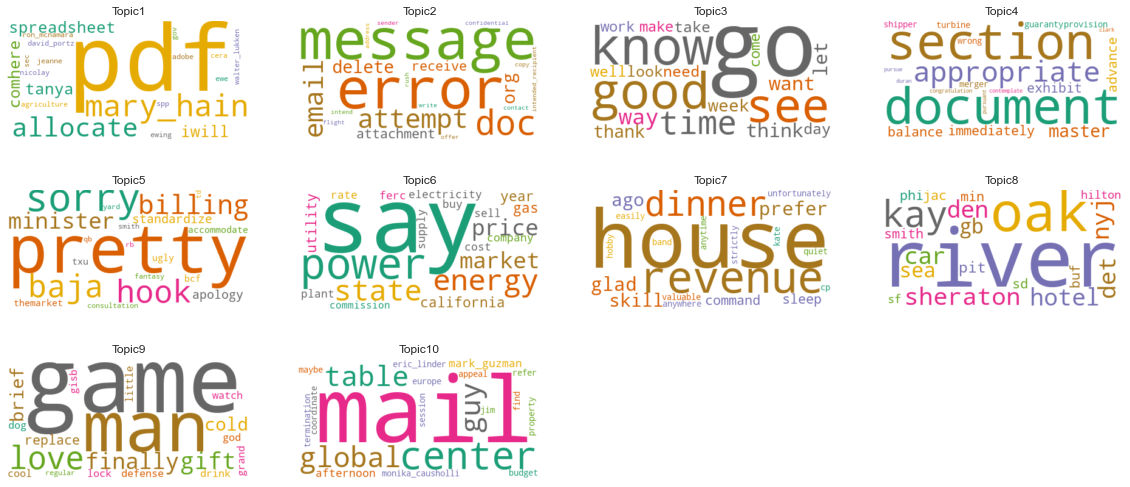

In [58]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()